In [46]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Exo1") \
    .getOrCreate()

In [84]:
dataframe = spark.read.csv("shop1.csv", header=True, inferSchema=True)
dataframe.show(5)
dataframe.printSchema()

+-------------------+------+----------+--------+---------+--------------------+--------------------+------+
|               date|amount|unit_price|clientId|productId|              family|         productName|cartId|
+-------------------+------+----------+--------+---------+--------------------+--------------------+------+
|2022-05-01 00:00:00|     2|        20|      74|        6|          Pâtisserie|    Fouet électrique|     1|
|2022-05-01 00:00:00|     5|         3|      74|        1|  Ustensiles de base|               Fouet|     1|
|2022-05-01 00:00:00|     1|        10|      74|        1|  Ustensiles de base|          Presse-ail|     1|
|2022-05-01 00:00:00|     8|        25|      74|        2|Appareils électro...|         Grille-pain|     1|
|2022-05-01 00:00:00|     9|        10|      74|        7|Couteaux et planc...|Planche à découpe...|     1|
+-------------------+------+----------+--------+---------+--------------------+--------------------+------+
only showing top 5 rows

roo

In [86]:
from pyspark.sql.functions import col, isnan, when, count, mean, stddev

missing_data = dataframe.select([count(when(col(c).isNull(), c)).alias(c) for c in dataframe.columns])
missing_data.show()

+----+------+----------+--------+---------+------+-----------+------+
|date|amount|unit_price|clientId|productId|family|productName|cartId|
+----+------+----------+--------+---------+------+-----------+------+
|   0|     0|         0|       0|        0|     0|          0|     0|
+----+------+----------+--------+---------+------+-----------+------+



In [92]:
dataframe.select('amount', 'unit_price').describe().show()

+-------+-----------------+-----------------+
|summary|           amount|       unit_price|
+-------+-----------------+-----------------+
|  count|            22417|            22417|
|   mean|5.494401570236874|25.99669893384485|
| stddev|2.875149713672134|308.4579031323496|
|    min|                1|                2|
|    max|               10|            10000|
+-------+-----------------+-----------------+



In [95]:
dataframe.orderBy('unit_price', ascending=False).show(100)

+-------------------+------+----------+--------+---------+--------------------+--------------------+------+
|               date|amount|unit_price|clientId|productId|              family|         productName|cartId|
+-------------------+------+----------+--------+---------+--------------------+--------------------+------+
|2022-12-01 00:00:00|     3|     10000|      19|        3|          Bar et vin|Chateau Lafitte 1992|   204|
|2022-05-01 00:00:00|     1|     10000|     100|        3|          Bar et vin|Chateau Lafitte 1992|     7|
|2022-04-01 00:00:00|     8|     10000|       6|        3|          Bar et vin|Chateau Lafitte 1992|     8|
|2022-09-01 00:00:00|     9|     10000|      56|        3|          Bar et vin|Chateau Lafitte 1992|    42|
|2022-11-01 00:00:00|     4|     10000|      76|        3|          Bar et vin|Chateau Lafitte 1992|    43|
|2022-11-01 00:00:00|    10|     10000|     101|        3|          Bar et vin|Chateau Lafitte 1992|    48|
|2022-12-01 00:00:00|     6|

In [102]:
dataframe.where((dataframe.productName == 'Chateau Lafitte 1992') & (dataframe.unit_price != 10000)).show()

+----+------+----------+--------+---------+------+-----------+------+
|date|amount|unit_price|clientId|productId|family|productName|cartId|
+----+------+----------+--------+---------+------+-----------+------+
+----+------+----------+--------+---------+------+-----------+------+



In [103]:
dataframe.where((dataframe.productName == 'Lave-linge') & (dataframe.unit_price != 4000)).show()


+----+------+----------+--------+---------+------+-----------+------+
|date|amount|unit_price|clientId|productId|family|productName|cartId|
+----+------+----------+--------+---------+------+-----------+------+
+----+------+----------+--------+---------+------+-----------+------+



In [49]:
numeric_cols = [c[0] for c in dataframe.dtypes if c[1] in ['int', 'float', 'double']]
stats = dataframe.select([mean(col(c)).alias(c + '_mean') for c in numeric_cols] +
                  [stddev(col(c)).alias(c + '_stddev') for c in numeric_cols]).collect()[0]
outliers = {}
for col_name in numeric_cols:
    mean_val = stats[col_name + '_mean']
    stddev_val = stats[col_name + '_stddev']
    outliers[col_name] = dataframe.filter((dataframe[col_name] > mean_val + 3 * stddev_val) |
                                   (dataframe[col_name] < mean_val - 3 * stddev_val)).count()
    
print("Outliers count per numeric column:", outliers)
print("Je sais pas c'est quoi un outlier mais selon le nombre de lignes total ça peut être négligeable.")
print("Nombre de lignes total : ", dataframe.count())
print("Conclusion : c'est bien négligeable.")

Outliers count per numeric column: {'amount': 0, 'unit_price': 34, 'clientId': 0, 'productId': 0, 'cartId': 0}
Je sais pas c'est quoi un outlier mais selon le nombre de lignes total ça peut être négligeable.
Nombre de lignes total :  22417
Conclusion : c'est bien négligeable.


In [81]:
print(dataframe.select('cartId').distinct().count())

5000


In [75]:
dataframe.groupby('family', 'productName', 'productId').count().orderBy('family', 'productName', 'productId').show()
print("C'est quoi cette colonne productId... Pourquoi il y a 475 articles bouilloires enregistrées ")


+--------------------+--------------------+---------+-----+
|              family|         productName|productId|count|
+--------------------+--------------------+---------+-----+
|Appareils électro...|          Bouilloire|        2|  475|
|Appareils électro...|         Grille-pain|        2|  440|
|Appareils électro...|          Lave-linge|        2|   15|
|Appareils électro...|      Machine à café|        2|  435|
|Appareils électro...|              Mixeur|        2|  456|
|Appareils électro...|     Robot culinaire|        2|  421|
|          Bar et vin|Chateau Lafitte 1992|        3|   19|
|          Bar et vin|           Décanteur|        9|  458|
|          Bar et vin|     Ouvre-bouteille|        9|  452|
|          Bar et vin|        Seau à glace|        9|  446|
|          Bar et vin|        Tire-bouchon|        9|  447|
|          Bar et vin|         Verre à vin|        9|  455|
|Couteaux et planc...|    Couteau d'office|        7|  448|
|Couteaux et planc...|     Couteau de ch

In [76]:
dataframe.groupby('family', 'productName', 'productId','clientId','date').count().orderBy('family', 'productName', 'productId','clientId','date').show()

+--------------------+-----------+---------+--------+-------------------+-----+
|              family|productName|productId|clientId|               date|count|
+--------------------+-----------+---------+--------+-------------------+-----+
|Appareils électro...| Bouilloire|        2|       1|2022-02-01 00:00:00|    2|
|Appareils électro...| Bouilloire|        2|       1|2022-09-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       2|2022-02-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       2|2022-03-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       2|2022-05-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       2|2022-11-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       3|2022-02-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       3|2022-04-01 00:00:00|    1|
|Appareils électro...| Bouilloire|        2|       3|2022-05-01 00:00:00|    1|
|Appareils électro...| Bouilloire|      

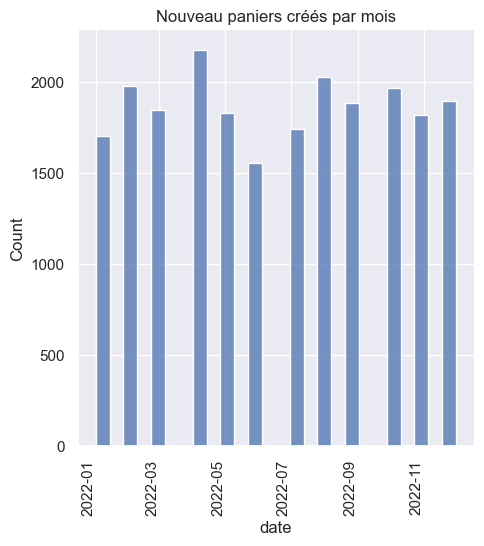

distribution régulière des créations d'article au cours de l'année, léger creux en été et à Noël qui correspond aux périodes de congés


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

col_to_plot = 'date'  # Remplacer par la colonne que vous souhaitez visualiser
data_pandas = dataframe.select(col_to_plot).dropna().toPandas()
#sns.histplot(data_pandas[col_to_plot], kde=True)
#sns.kdeplot(data_pandas[col_to_plot])
sns.displot(data_pandas[col_to_plot])
plt.title(f'Nouveau paniers créés par mois')
plt.xticks(rotation=90, ha='right')
plt.show()
print("distribution régulière des créations de paniers au cours de l'année, léger creux en été et à Noël qui correspond aux périodes de congés")

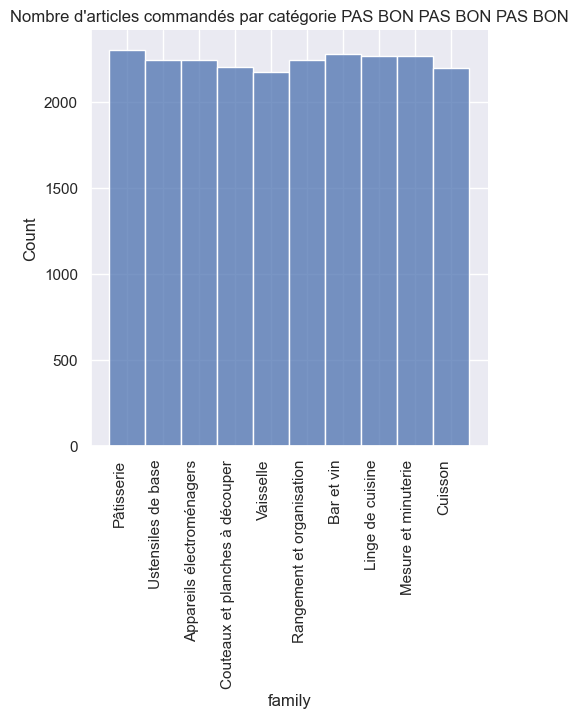

distribution très régulière des commandes d'articles par catégorie PAS BON PAS BON PAS BON


In [115]:
col_to_plot = 'family'  # Remplacer par la colonne que vous souhaitez visualiser
data_pandas = dataframe.select(col_to_plot).dropna().toPandas()
sns.displot(data_pandas[col_to_plot])
plt.title(f'Nombre d\'articles commandés par catégorie PAS BON PAS BON PAS BON')
plt.xticks(rotation=90, ha='right')
plt.show()
print("distribution très régulière des commandes d\'articles par catégorie PAS BON PAS BON PAS BON")

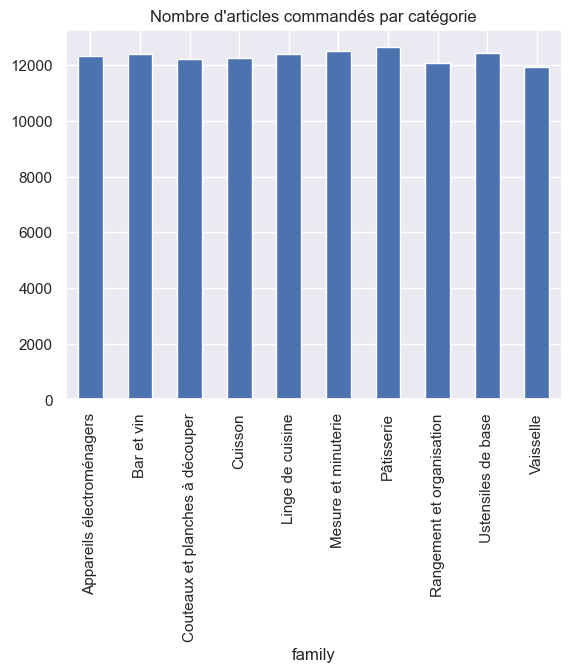

distribution très régulière des commandes d'articles par catégorie


In [114]:
data_pandas = dataframe.select('family', 'amount').dropna().toPandas()
montant_par_categorie = data_pandas.groupby('family')['amount'].sum()
montant_par_categorie.plot(kind='bar')
plt.title(f'Nombre d\'articles commandés par catégorie')
plt.show()
print("distribution très régulière des commandes d\'articles par catégorie")

In [112]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

dataframe.withColumn('family', ).show()

dataframe.show()


PySparkTypeError: [SHOULD_NOT_DATAFRAME] Argument `data` should not be a DataFrame.

In [ ]:
correlation_matrix = dataframe.select(numeric_cols, 'family_encoded').toPandas().corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()
print("Ça marche pas mais il y avait aucune relation entre les colonnes hors 'family'. Avec la colonne family je m'attends à voir éventuellement une relation entre le prix et la catégorie et le montant en stock et la catégorie, mais rien de significatif.")